In [1]:
from langgraph.graph import START ,END ,StateGraph
from typing import Annotated
from typing_extensions import TypedDict
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode ,tools_condition
from langgraph.graph.message import add_messages,BaseMessage
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
from langgraph.types import Command , interrupt
load_dotenv()

True

In [2]:
os.environ["GROQ_API_key"] = os.getenv("GROQ_API_KEY")
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"

In [3]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("groq:llama3-8b-8192")

In [4]:
class State(TypedDict):
    messages : Annotated[list, add_messages]

In [5]:
from langchain_core.tools import tool

@tool
def add(a:float , b:float):
    """add number"""
    return a+b

tools = [add]
tool_node = ToolNode([add])
llm_with_tools = llm.bind_tools(tools)
def call_llm_model(state:State):
    return {"messages":[llm_with_tools.invoke(state['messages'])]}



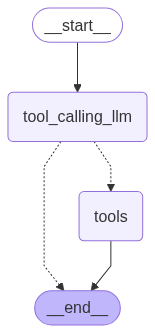

In [6]:
from langgraph.graph import START ,END , StateGraph
from langgraph.prebuilt import ToolNode ,tools_condition
# it is used for cheking which tool is used by llm 

from langgraph.checkpoint.memory import MemorySaver


memory = MemorySaver()


def call_llm_model(state:State):
    return {"messages":[llm_with_tools.invoke(state['messages'])]}

# graph 
builder = StateGraph(State)
builder.add_node("tool_calling_llm",call_llm_model)
builder.add_node("tools" , ToolNode(tools))

builder.add_edge(START , "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # if the latest message from assistant is tool call -> tool conditon routes to tools 
    # if the latest message from assistant is not a tool call -> tool condition routes to END 
    # that is what tools_condition does 
    tools_condition
)

builder.add_edge("tools" , END)    
# you can make it react agent architecture as well   END->tool_calling_llm

graph = builder.compile()
graph

In [8]:
response = graph.invoke({"messages" : "what is machine learning ?"})
response

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool-use>\n{\n  "tool_calls": [\n    {\n      "id": "pending",\n      "type": "function",\n      "function": {\n        "name": "explain_machine_learning"\n      },\n      "parameters": {\n        "format": "simple"\n      }\n    }\n  ]\n}\n</tool-use>'}}